In [63]:
#pip install prophet

In [64]:
#-------------------- Define crime type, area and training month limit ----------------------------------

crime_type='Theft'
area='Khulna div'
train_limit='2024-01-01'
test_limit1='2024-01-01'
test_limit2='2024-06-01'

In [65]:
#..........................crime prediction of Bangladesh using PROPHET Model .................................

from prophet import Prophet
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
import warnings
import itertools
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

#Read dataset
df_data_pro = pd.read_csv("https://raw.githubusercontent.com/rroxy08/BD-crime-data/refs/heads/main/BD_police_crime_data.csv")

## put the data till july 2024
df_data_pro=df_data_pro[df_data_pro['Month']<202407]

#-----------------------------choose dataset from Area and crime_type ------------------------
df_data_pro1=df_data_pro[df_data_pro['Area']==area]
df_data=df_data_pro1[['Month',crime_type]]

df_data['Month']=pd.to_datetime(df_data['Month'].astype(str),format='%Y%m')

#--------------------------divide into test and train dataset in year ---------------------------

df_data_train = df_data[df_data['Month'] < train_limit]
df_data_test = df_data[(df_data['Month'] >= test_limit1) & (df_data['Month'] <= test_limit2)]

print(df_data.tail)

<bound method NDFrame.tail of          Month  Theft
316 2019-01-01     36
317 2019-02-01     41
318 2019-03-01     36
319 2019-04-01     28
320 2019-05-01     35
..         ...    ...
377 2024-02-01     61
378 2024-03-01     73
379 2024-04-01     58
380 2024-05-01     48
381 2024-06-01     49

[66 rows x 2 columns]>


/tmp/ipython-input-1216623090.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['Month']=pd.to_datetime(df_data['Month'].astype(str),format='%Y%m')


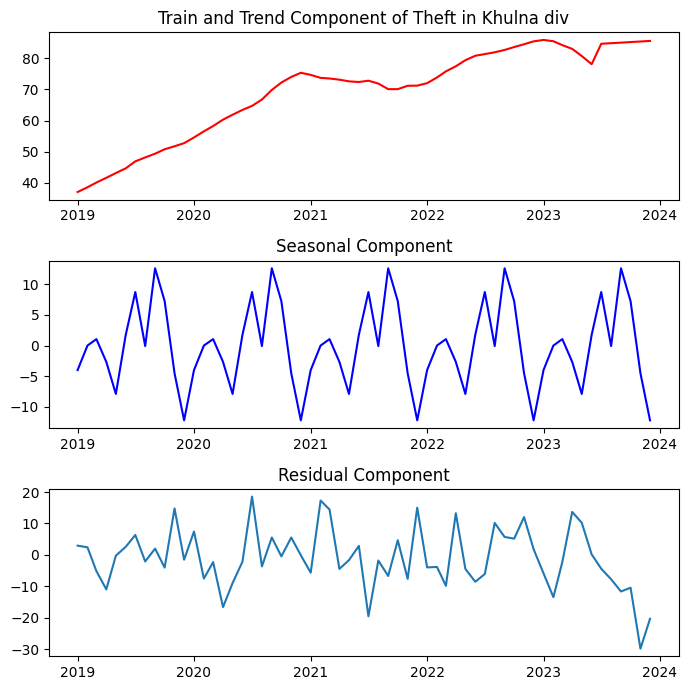

In [66]:
#------------------------- overall trend -------------------------------

from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df_data_train[crime_type], model='additive', extrapolate_trend='freq', period=12)
season_value=np.sum(decompose.seasonal)

std_train=np.std(df_data_train[crime_type])

#decompose.plot().show()


# Plot the decomposition components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 7))

#ax1.plot(df_data_train['Month'], df_data_train[crime_type], label='Trend', color='green')

ax1.plot(df_data_train['Month'], decompose.trend, label='Trend', color='red')
ax1.set_title('Train and Trend Component of '+ crime_type+ " in "+ area)

ax2.plot(df_data_train['Month'], decompose.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(df_data_train['Month'], decompose.resid, label='Residual')
ax3.set_title('Residual Component')
plt.tight_layout()
plt.show()
#------------------------------------------------------------------
dd = decompose.resid
Z_Score = np.abs((dd - dd.mean()) / dd.std())
outliers_stl = Z_Score[Z_Score > 2]

#print("Residual:", dd)
#print("Number of outliers:",outliers_stl.shape[0])



ACF significant value:  [0 1 2 3 4]
PACF significant value:  [ 0  1 14 21 28 29]
Seasonal lags:  [0 0 0 0 0]
PSeasonal lags:  [0 0 0 0 0 0]
Non seasonal order p and q:  1
4
Seasonal order P and Q:  0
0
prophet_year_limit value:  4


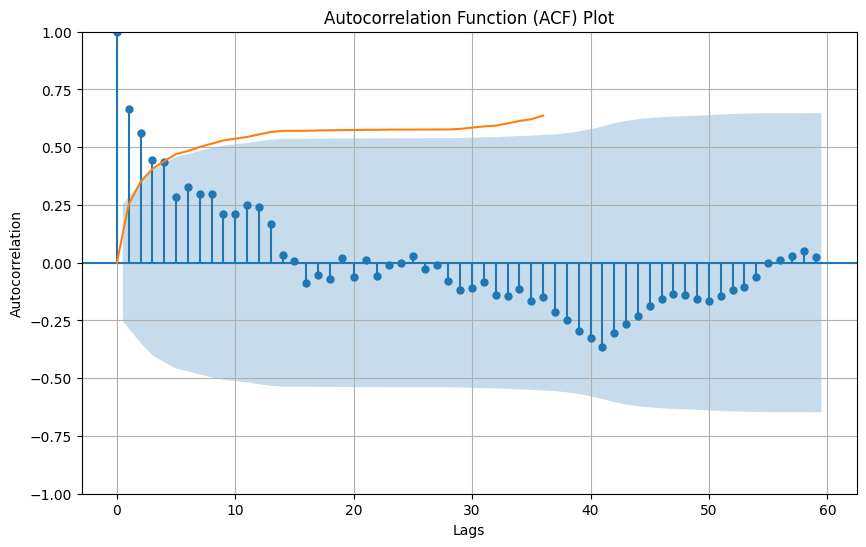

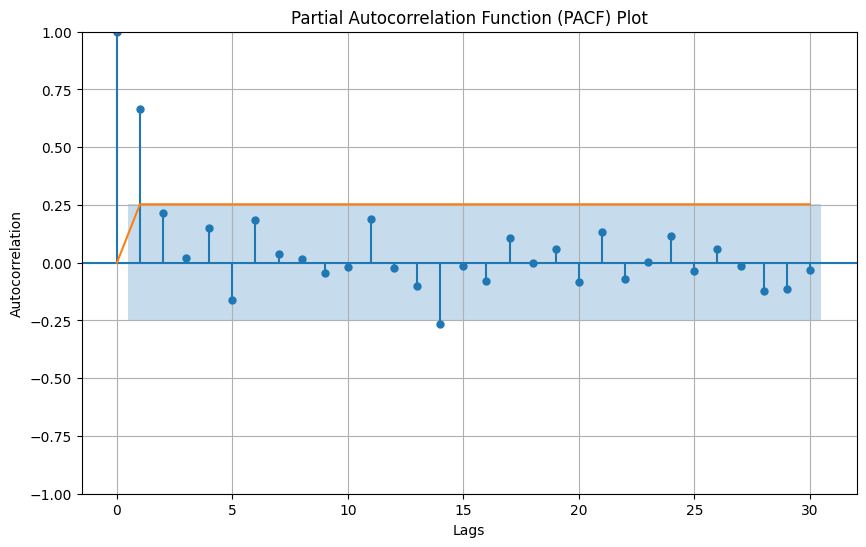

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import math
from statsmodels.tsa.stattools import acf, pacf

# Create a sample time series (replace with your actual data)
data = df_data_train[crime_type]
prophet_year_limit=2

#ACF function

acf_values, conf_int = acf(data, alpha=0.05, fft=True, nlags=36, adjusted=True)
ci_width = (conf_int[:, 1] - conf_int[:, 0]) / 2   # test if the value is beyond blue bar

significant_lags = np.where(np.abs(acf_values) > ci_width)[0]


# alpha parameter is significance level (e.g., 0.05 for 95% confidence)
pacf_values, pconf_int = pacf(data, nlags=30, alpha=0.05)

pci_width = (pconf_int[:, 1] - pconf_int[:, 0]) / 2
psignificant_lags = np.where(np.abs(pacf_values) > pci_width)[0]

#---------------------------------Set SARIMAX P  and q order ------------------------------------------
print("ACF significant value: ",significant_lags)
print("PACF significant value: ",psignificant_lags)

q_order=0
p_order=0

#q_order = len([item for item in significant_lags if item < 13])-1
#p_order = len([item for item in psignificant_lags if item < 13])-1

#Set q and p order

prophet_index=0
for itr,item in enumerate(significant_lags):

  if itr>0 and item-significant_lags[itr-1]==1:
    q_order=item
    prophet_index=itr
  elif itr>0 and item-significant_lags[itr-1]>1:
    break


for itr,item in enumerate(psignificant_lags):

  if itr>0 and item-psignificant_lags[itr-1]==1:
    p_order=item

  elif itr>0 and item-psignificant_lags[itr-1]>1:
    break

seasonal_lags= np.where(significant_lags % 12 ==0, significant_lags, 0)
pseasonal_lags= np.where(psignificant_lags % 12 ==0, psignificant_lags, 0)

print("Seasonal lags: ",seasonal_lags)
print("PSeasonal lags: ",pseasonal_lags)

Q_order = len([item for item in seasonal_lags if item > 0])
P_order = len([item for item in pseasonal_lags if item > 0])

if p_order==0:
  p_order=1
if q_order==0:
  q_order=1

print("Non seasonal order p and q: ",p_order)
print(q_order)

print("Seasonal order P and Q: ",Q_order)
print(P_order)

#----------------------- set prophet cap and floor limit within range -------------------------
if len(significant_lags)>1:
  prophet_year_limit=significant_lags[prophet_index]
  if prophet_year_limit<2:
    prophet_year_limit=2


print("prophet_year_limit value: ",prophet_year_limit)
#------------------------------------------------------------------------


# Plot the ACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(data,lags=59,alpha=0.05, ax=ax) # You can adjust the number of lags
plt.plot(ci_width)
plt.title("Autocorrelation Function (ACF) Plot")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.grid(True)

fig, ax = plt.subplots(figsize=(10, 6))

plot_pacf(data, lags=30, ax=ax,alpha=0.05) # You can adjust the number of lags
plt.plot(pci_width)
plt.title("Partial Autocorrelation Function (PACF) Plot")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

In [68]:
#To fit models in Prophet, it is important to have at least a ‘ds’ (datestamp) and ‘y’ (value to be forecasted) column.
#We should make sure that our columns are renamed the reflect the same.

df_train_prophet = df_data_train

df_test_prophet =df_data_test

#print(df_train_prophet[crime_type][-6:])

seasonality_scale=0.03
growth_value='logistic'

print("CAP and FLOOR limit range", prophet_year_limit)

cap = df_train_prophet[crime_type].max()
flr = df_train_prophet[crime_type].min()
df_train_prophet['cap'] = cap
df_train_prophet['floor'] = flr

future_cap = df_train_prophet[crime_type][-prophet_year_limit:].max()   # take the cap and floor of future data based on data correlation of train data.
future_flr = df_train_prophet[crime_type][-prophet_year_limit:].min()

# Month variable needs to be named "ds" for prophet
df_train_prophet = df_train_prophet.rename(columns={"Month": "ds"})

# target variable needs to be named "y" for prophet
df_train_prophet = df_train_prophet.rename(columns={f'{crime_type}': "y"})

#----------------------------prohet model fit-----------------------------------------
model_prophet  = Prophet(growth=growth_value, yearly_seasonality='auto',
                 seasonality_mode='additive',interval_width=0.80,
                 changepoint_range = 0.8,seasonality_prior_scale=seasonality_scale)

model_prophet.fit(df_train_prophet)


#---------------------------predict for next test size periods-----------------------------------
df_future = model_prophet.make_future_dataframe(periods=df_test_prophet['Month'].size, freq='MS')

/tmp/ipython-input-881662687.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_prophet['cap'] = cap
/tmp/ipython-input-881662687.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_prophet['floor'] = flr
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprzoth1p8/p9zxhiyb.json
DEBUG:cmdstanpy:input

CAP and FLOOR limit range 4


05:19:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [69]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error, accuracy_score
import numpy as np


df_future['cap'] = future_cap
df_future['floor'] = future_flr

forecast_prophet = model_prophet.predict(df_future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

pred_data=forecast_prophet[['ds', 'yhat']].round()


#----------------------predicted data range till July 2024----------------------------------------

predicted_data_24=pred_data[pred_data['ds']>=train_limit]

test_data_24=df_test_prophet

#---------------Error for 2024 data--------------------------------------

#print(predicted_data_24)
#print(test_data_24)

scre_24= r2_score(test_data_24[crime_type], predicted_data_24.yhat,sample_weight=None, multioutput='uniform_average', force_finite=True)
mae_24=mean_absolute_error(test_data_24[crime_type], predicted_data_24.yhat)
mape_24=mean_absolute_percentage_error(test_data_24[crime_type], predicted_data_24.yhat)
mse_24=mean_squared_error(test_data_24[crime_type], predicted_data_24.yhat)
rmse_24 = np.sqrt(mse_24)

print(f"\n Prophet model Error value on predicting till june 2024 data for {crime_type} of {area} \n")
print("Mean Absolute Error = ",round(mae_24,2))
print(f"Mean Absolute Percentage Error = {round(mape_24*100, 2) }%")
print(f"Root Mean Square Error (RMSE): {round(rmse_24,2)}")
print("r2 score = ",round(scre_24,2))


 Prophet model Error value on predicting till june 2024 data for Theft of Khulna div 

Mean Absolute Error =  21.0
Mean Absolute Percentage Error = 38.67%
Root Mean Square Error (RMSE): 22.29
r2 score =  -6.17


Theft


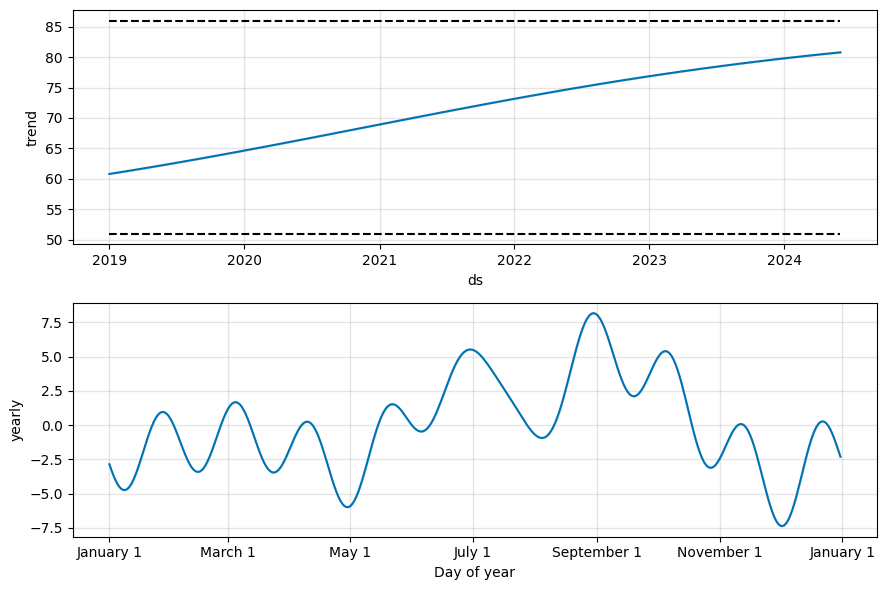

In [70]:
import matplotlib.pyplot as plt
#get the trend on prediction
print(crime_type)

fig2 = model_prophet.plot_components(forecast_prophet)
#plt.title(f"Trend of predicted data {crime_type} of {area}")

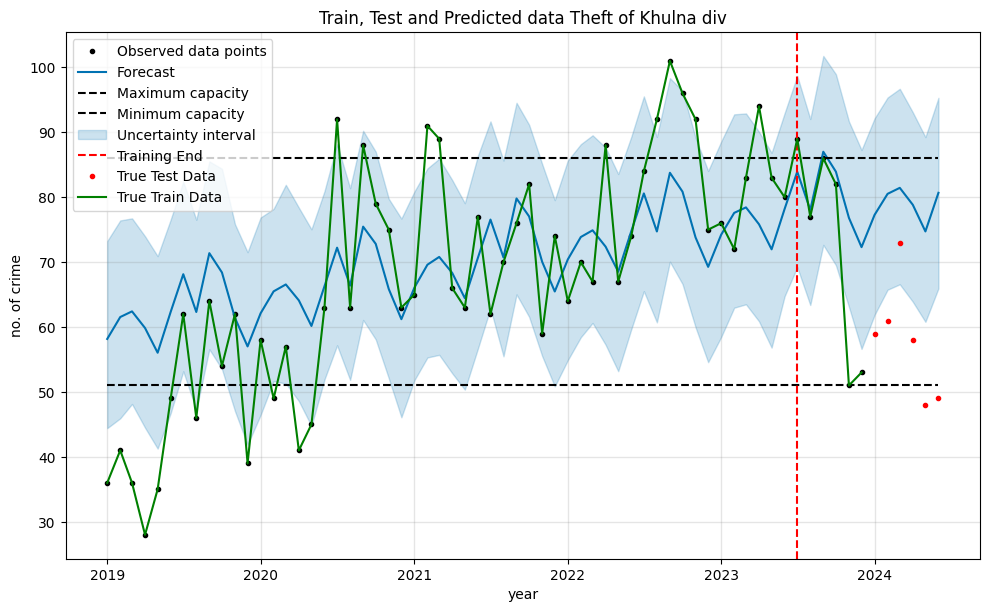

In [71]:
import matplotlib.pyplot as plt

# plot the time series


forecast_plot = model_prophet.plot(forecast_prophet, ylabel='no. of crime', xlabel='year')

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-12]

axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after the red line

#df_test_date['Month']=pd.to_datetime(df_test_date['Month'])
plt.plot(df_data_test['Month'], df_data_test[crime_type],'ro', markersize=3, label='True Test Data')
plt.plot(df_data_train['Month'], df_data_train[crime_type], markersize=3, label='True Train Data',color='green')

plt.title(f"Train, Test and Predicted data {crime_type} of {area}")

# show the legend to distinguish between the lines
plt.legend()

In [72]:
###################### SARIMA MODEL ##########################

#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.stattools import adfuller
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import warnings
#import itertools
#import math
#from statsmodels.tsa.stattools import acf, pacf

#------------------ Load dataset-----------------

#df_data_arima_all = pd.read_csv("https://raw.githubusercontent.com/rroxy08/BD-crime-data/refs/heads/main/BD_police_crime_data.csv")


#-----------------------------choose dataset from Area and crime_type ------------------------

#df_data_arima2=df_data_arima_all[df_data_arima_all['Area']==area]

#df_data_arima=df_data_arima2[['Month',crime_type]]

#df_data_arima['Month']=pd.to_datetime(df_data_arima['Month'].astype(str),format='%Y%m')


#--------------------------divide into test and train dataset in year ---------------------------

#df_data_train = df_data_arima[df_data_arima['Month'] < train_limit]
#df_data_test = df_data_arima[(df_data_arima['Month'] >= test_limit1) & (df_data_arima['Month'] <= test_limit2)]
#print(area)
#print(df_data_test.tail())


In [73]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


#--------------------------------------- Cho0se order --------------------------------
#p = range(0, 3)
#q = range(0, 3)

if p_order==1:
  p=[p_order,]
else:
  p = range(1, p_order)

if q_order==1:
  q=[q_order,]
else:
  q = range(1, q_order)

df_data_train = df_data_train.dropna()

stationery_result = adfuller(df_data_train[crime_type])
print('ADF Statistic: %f' % stationery_result[0])
print('p-value: %f' % stationery_result[1])

if stationery_result[1] > 0.05:
    print("Series is non stationary; differencing is needed.")
    d = range(1, 3)
else:
    print("Series is stationary; no differencing needed.")
    d = [0,]

pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
best_model = None

for orders in pdq:
    try:
        model = SARIMAX(df_data_train[crime_type], order=orders)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = orders
            best_model = results
    except:
        continue

print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')

ADF Statistic: -3.491608
p-value: 0.008205
Series is stationary; no differencing needed.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot

Best ARIMA order: (np.int64(1), 0, 1) with AIC: 482.704287575526


In [74]:
#--------------------------------------- seasonal Chose order --------------------------------
from statsmodels.tsa.seasonal import seasonal_decompose

#seasonal order is based on the presence of seasonality
if P_order>1:
  p=range(0, P_order)
else:
  p=[P_order,]

if Q_order>1:
  q=range(0, Q_order)
else:
  q=[Q_order,]

#--------------------------- stationarity of seasonal data -------------------------------

result = seasonal_decompose(df_data_train[crime_type], model='additive', extrapolate_trend='freq', period=12)
seasonal_stationary = adfuller(result.seasonal)
print('ADF Statistic: %f' % seasonal_stationary[0])
print('p-value: %f' % seasonal_stationary[1])

if seasonal_stationary[1] > 0.05:
    print("Seasonal data is non stationary; differencing is needed.")
    d = [1,]
else:
    print("Seasonal data is stationary; no differencing needed.")
    d = [0,]


#------------------------------------------------------------------------

pdqs = list(itertools.product(p, d, q))

best_aic = np.inf
best_seasonal_order = None
best_model = None
best_seasonal_order=None

for sorder in pdqs:
    new_sorder = sorder + (12,)
    try:
        model = SARIMAX(df_data_train[crime_type], order=best_order, seasonal_order=new_sorder)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_seasonal_order = new_sorder
            best_model = results
    except:
        continue

print(f'Best SARIMA seasonal order: {best_seasonal_order} with AIC: {best_aic}')

ADF Statistic: -2914628070397925.000000
p-value: 0.000000
Seasonal data is stationary; no differencing needed.
Best SARIMA seasonal order: (0, 0, 0, 12) with AIC: 482.704287575526


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [75]:
#---------------------------------- fit the seasonal ARIMA model and predict --------------------------------

final_model = SARIMAX(df_data_train[crime_type],order=best_order,seasonal_order =best_seasonal_order)

steps=df_data_test['Month'].size
results = final_model.fit()
predict_arima= results.predict(start=df_data_train['Month'].size, end=df_data_train['Month'].size+steps-1)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

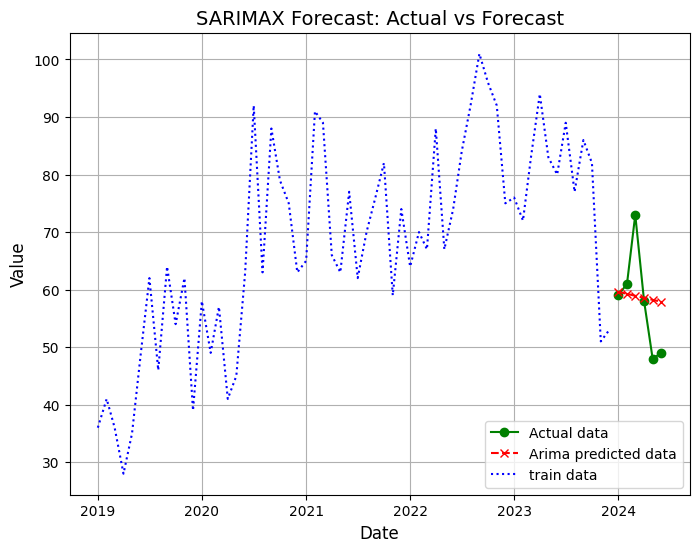

In [76]:
#---------------------------------------------Plot arima prediction ----------------------------------
forecast_arima=round(predict_arima,2)

plt.figure(figsize=(8, 6))
plt.plot(df_data_test['Month'], df_data_test[crime_type], label='Actual data', color='green', linestyle='-', marker='o')
plt.plot(df_data_test['Month'], forecast_arima, label='Arima predicted data', color='red', linestyle='--', marker='x')
plt.plot(df_data_train['Month'],df_data_train[crime_type], label='train data',color='blue',linestyle=':')

plt.title('SARIMAX Forecast: Actual vs Forecast', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error, accuracy_score
import numpy as np

y_test_arima=df_data_test[crime_type]


scre_arima= r2_score(y_test_arima,forecast_arima,sample_weight=None, multioutput='uniform_average', force_finite=True)
mae_arima=mean_absolute_error(y_test_arima,forecast_arima)
mape_arima=mean_absolute_percentage_error(y_test_arima,forecast_arima)
mse_arima=mean_squared_error(y_test_arima,forecast_arima)
rmse_arima = np.sqrt(mse_arima)


print(f"SARIMAX model Error value on predicting 2024 data for {crime_type} in {area} \n")
print("Mean Absolute Error = ",round(mae_arima,2))
print(f"Mean Absolute Percentage Error = {round(mape_arima*100, 2) }%")
print(f"Root Mean Square Error (RMSE)= {round(rmse_arima,2)}")
print("R2 scre = ",round(scre_arima,2))

SARIMAX model Error value on predicting 2024 data for Theft in Khulna div 

Mean Absolute Error =  6.02
Mean Absolute Percentage Error = 10.6%
Root Mean Square Error (RMSE)= 8.01
R2 scre =  0.07


In [78]:
#crime prediction of Bangladesh
#################################### Random Forest/ XGBOOST ##############################################

import pandas as pd
import matplotlib.pyplot as plt

#Read dataset
df_data_pro = pd.read_csv("https://raw.githubusercontent.com/rroxy08/BD-crime-data/refs/heads/main/BD_police_crime_data.csv")


#-----------------------------choose dataset from Area and crime_type ------------------------
df_data_pro1=df_data_pro[df_data_pro['Area']==area]
df_data=df_data_pro1[['Month',crime_type]]

#--------------------------divide into test and train dataset in year ---------------------------

df_data['Month']=pd.to_datetime(df_data['Month'].astype(str),format='%Y%m')
df_data_train = df_data[df_data['Month'] < train_limit]
df_data_test = df_data[(df_data['Month'] >= test_limit1) & (df_data['Month'] <= test_limit2)]

#df_data['Datetime']=pd.to_datetime(df_data['Month'].astype(str),format='%Y%m')
#df_data_train = df_data[df_data['Datetime'] < train_limit]
#df_data_test = df_data[(df_data['Datetime'] >= test_limit1) & (df_data['Datetime'] <= test_limit2)]

/tmp/ipython-input-429651298.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['Month']=pd.to_datetime(df_data['Month'].astype(str),format='%Y%m')


In [79]:
#################################### Random forest/ XGBOOST##############################################

##-------------------- performance improves for year and month separate column ----------------------

df_train_boost=df_data_train[['Month', crime_type]]
df_test_boost=df_data_test[['Month', crime_type]]


df_train_boost['year_col'] = df_train_boost['Month'].dt.year
df_train_boost['month_col'] = df_train_boost['Month'].dt.month

X_train_boost = df_train_boost.drop(['Month'], axis=1)
X_train_boost = X_train_boost.drop([crime_type], axis=1)
y_train_boost = df_train_boost[crime_type]
y_train_boost=df_train_boost.drop(['Month','year_col','month_col'], axis=1)

df_test_boost['year_col'] = df_test_boost['Month'].dt.year
df_test_boost['month_col'] = df_test_boost['Month'].dt.month

X_test_boost = df_test_boost.drop(['Month'], axis=1)
X_test_boost = X_test_boost.drop([crime_type], axis=1)
y_test_boost = df_test_boost[crime_type]
y_test_boost=df_test_boost.drop(['Month','year_col','month_col'], axis=1)


#print(X_test_boost)

In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error, accuracy_score
import numpy as np

#-----------------------------------Random forest regressor to predict----------------------------------

reg = RandomForestRegressor(random_state=25)

reg.fit(X_train_boost, y_train_boost)

preds_gbc = reg.predict(X_test_boost)

preds_gbc = np.round(preds_gbc)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Regressor Error value on predicting 2024 data for Theft in Khulna div 

Mean Absolute Error =  22.83
Mean Absolute Percentage Error = 42.34%
Root Mean Square Error (RMSE): 25.12
R2 scre =  -8.1


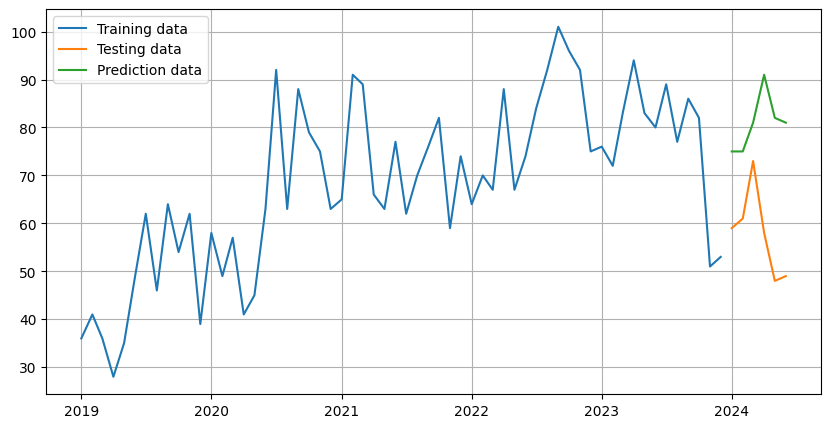

In [81]:
############### Error calculation ###################################

scre_gbc= r2_score(y_test_boost, preds_gbc,sample_weight=None, multioutput='uniform_average', force_finite=True)
mae_gbc=mean_absolute_error(y_test_boost, preds_gbc)
mape_gbc=mean_absolute_percentage_error(y_test_boost, preds_gbc)
mse_gbc=mean_squared_error(y_test_boost, preds_gbc)
rmse_gbc = np.sqrt(mse_gbc)

print(f"Random Forest Regressor Error value on predicting 2024 data for {crime_type} in {area} \n")
print("Mean Absolute Error = ",round(mae_gbc,2))
print(f"Mean Absolute Percentage Error = {round(mape_gbc*100, 2) }%")
print(f"Root Mean Square Error (RMSE): {round(rmse_gbc,2)}")
print("R2 scre = ",round(scre_gbc,2))

####################################################33
figure, ax = plt.subplots(figsize=(10, 5))
plt.plot(df_train_boost['Month'],y_train_boost, label="Training data")
plt.plot(df_test_boost['Month'],y_test_boost, label="Testing data")
plt.plot(df_test_boost['Month'],preds_gbc, label="Prediction data")

plt.legend()
plt.grid()
plt.show()

XGBoost Error value on predicting 2025 data for Theft in Khulna div 

Mean Absolute Error =  23.33
Mean Absolute Percentage Error = 43.13%
Root Mean Square Error (RMSE): 25.79
R2 scre =  -8.6


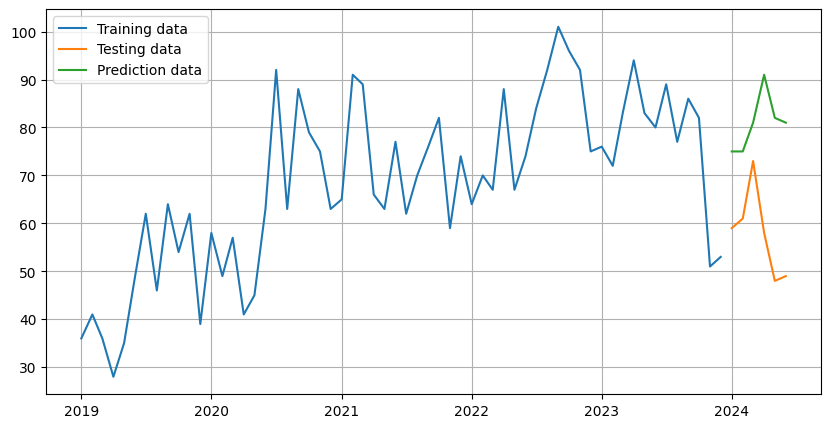

In [82]:

from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error, accuracy_score
import numpy as np


gbc = xgb.XGBRegressor()

#gbc = xgb.XGBRegressor(n_estimators = 300, learning_rate = 0.01, random_state = 34, verbosity = 0)

gbc.fit(X_train_boost, y_train_boost, verbose=False)

preds_xgb = gbc.predict(X_test_boost)

preds_xgb = np.round(preds_xgb)
#####################################################################

scre_xgb= r2_score(y_test_boost, preds_xgb,sample_weight=None, multioutput='uniform_average', force_finite=True)
mae_xgb=mean_absolute_error(y_test_boost, preds_xgb)
mape_xgb=mean_absolute_percentage_error(y_test_boost, preds_xgb)
mse_xgb=mean_squared_error(y_test_boost, preds_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print(f"XGBoost Error value on predicting 2025 data for {crime_type} in {area} \n")
print("Mean Absolute Error = ",round(mae_xgb,2))
print(f"Mean Absolute Percentage Error = {round(mape_xgb*100, 2) }%")
print(f"Root Mean Square Error (RMSE): {round(rmse_xgb,2)}")
print("R2 scre = ",round(scre_xgb,2))

####################################################33
figure, ax = plt.subplots(figsize=(10, 5))
plt.plot(df_train_boost['Month'],y_train_boost, label="Training data")
plt.plot(df_test_boost['Month'],y_test_boost, label="Testing data")
plt.plot(df_test_boost['Month'],preds_gbc, label="Prediction data")

plt.legend()
plt.grid()
plt.show()

In [83]:
#crime prediction of Bangladesh
#################################### keras LSTM/SVM regressor ##############################################

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,BatchNormalization
from keras.layers import LSTM, Dense, Input


#Read dataset
#df_data_pro = pd.read_csv("https://raw.githubusercontent.com/rroxy08/BD-crime-data/refs/heads/main/BD_police_crime_data.csv")

#-----------------------------choose dataset from Area and crime_type ------------------------
df_data_pro1=df_data_pro[df_data_pro['Area']==area]
df_data=df_data_pro1[['Month',crime_type]]

#df_data['Month']=pd.to_datetime(df_data['Month'].astype(str),format='%Y%m')
df_data['Datetime']=pd.to_datetime(df_data['Month'].astype(str),format='%Y%m')

#--------------------------divide into test and train dataset in year ---------------------------

#df_data_train = df_data[df_data['Month'] < train_limit]
#df_data_test = df_data[(df_data['Month'] >= train_limit) & (df_data['Month'] <= test_limit)]

df_data_train = df_data[df_data['Datetime'] < train_limit]
df_data_test = df_data[(df_data['Datetime'] >= test_limit1) & (df_data['Datetime'] <= test_limit2)]

/tmp/ipython-input-2206358442.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['Datetime']=pd.to_datetime(df_data['Month'].astype(str),format='%Y%m')


In [84]:
  import statsmodels.api as sm
  from statsmodels.stats.stattools import durbin_watson
  import pandas as pd

  X = df_data_train['Month']
  y = df_data_train[crime_type]

  # Fit the OLS regression model
  model = sm.OLS(y, X).fit()
  dw_statistic = durbin_watson(model.resid)
  print(f"Durbin-Watson statistic: {dw_statistic}")

Durbin-Watson statistic: 0.6071292814246944


In [85]:
df_train_lstm=df_data_train[['Month',crime_type]]
df_test_lstm=df_data_test[['Month',crime_type]]


y_train_lstm=df_train_lstm[crime_type].astype(float).values.reshape(-2, 1)
y_test_lstm=df_test_lstm[crime_type].astype(float).values.reshape(-2, 1)

X_train_lstm=df_train_lstm['Month'].astype(float).values.reshape(-2, 1)
X_test_lstm=df_test_lstm['Month'].astype(float).values.reshape(-2, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
obj = scaler.fit(y_train_lstm)
#scaler=StandardScaler()

y_train_scaled=scaler.fit_transform(y_train_lstm)
y_test_scaled=scaler.fit_transform(y_test_lstm)

X_train_scaled=scaler.fit_transform(X_train_lstm)
X_test_scaled=scaler.fit_transform(X_test_lstm)

#print(X_train_lstm)
#print(y_train_lstm[:5])

In [86]:
from tensorflow.keras.optimizers import Adam


model = Sequential()
model.add(LSTM(units=10,return_sequences=False, activation='linear',input_shape=(X_test_lstm.shape[0],1)))
model.add(Dropout(0.3))
model.compile(optimizer=Adam(learning_rate=0.02), loss='mae',metrics=['mse', 'mae', 'mape','accuracy'])

model.add(Dense(units=1)) # Output layer for single-step prediction

# ---------------------------------3. Model Training with small unit -----------------------------

history=model.fit(X_train_scaled, y_train_scaled, epochs=100,verbose=0, batch_size=50,validation_split=0.2, shuffle=False)

# 4. Forecasting and Evaluation
predictions_lstm = model.predict(X_test_scaled,batch_size=10)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


In [87]:
# Inverse transform the predictions and actual values to original scale

obj = scaler.fit(y_train_lstm)
pred_lstm_rescaled = scaler.inverse_transform(predictions_lstm)
y_test_rescaled = scaler.inverse_transform(y_test_scaled)

# Display the first few predicted and actual values

#print(pred_lstm_rescaled)
#print(y_test_lstm)
#print(y_test_rescaled)

LSTM Error value on predicting 2024 data for Theft in Khulna div 

Mean Absolute Error =  19.93
Mean Absolute Percentage Error = 38.49%
Root Mean Square Error (RMSE): 25.55
R2 scre =  -8.42


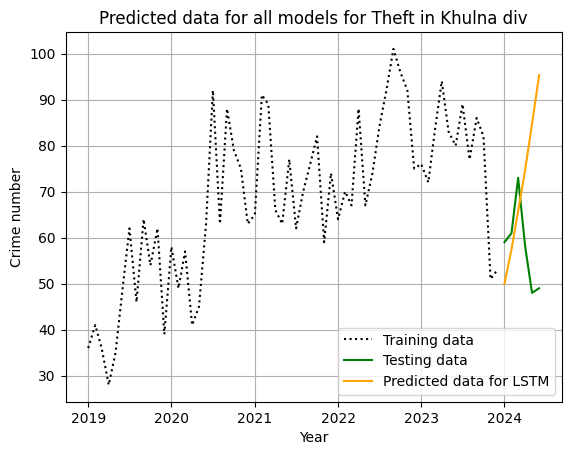

In [88]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

preds_lstm = np.round(pred_lstm_rescaled)

######################## Error calculation of LSTM compare between original test data and denormalized predicted data ##########################3

scre_lstm= r2_score(y_test_lstm, pred_lstm_rescaled,sample_weight=None, multioutput='uniform_average', force_finite=True)
mae_lstm=mean_absolute_error(y_test_lstm, pred_lstm_rescaled)
mape_lstm=mean_absolute_percentage_error(y_test_lstm, pred_lstm_rescaled)
mse_lstm=mean_squared_error(y_test_lstm, pred_lstm_rescaled)
rmse_lstm = np.sqrt(mse_lstm)
#correlation_matrix_gbc = np.corrcoef(y_test_boost, preds_gbc)
#acc_score_lstm=accuracy_score(y_test, preds_lstm)

print(f"LSTM Error value on predicting 2024 data for {crime_type} in {area} \n")
print("Mean Absolute Error = ",round(mae_lstm,2))
print(f"Mean Absolute Percentage Error = {round(mape_lstm*100, 2)}%")
print(f"Root Mean Square Error (RMSE): {round(rmse_lstm,2)}")
print("R2 scre = ",round(scre_lstm,2))


plt.title(f"Predicted data for all models for {crime_type} in {area}")
plt.xlabel('Year')
plt.ylabel('Crime number')

plt.plot(df_data_train['Datetime'],y_train_lstm, label="Training data",color='black',linestyle=':')
plt.plot(df_data_test['Datetime'],y_test_lstm, label="Testing data",color='green')
plt.plot(df_data_test['Datetime'],pred_lstm_rescaled, label="Predicted data for LSTM",color='orange')


plt.legend()
plt.grid()
plt.show()

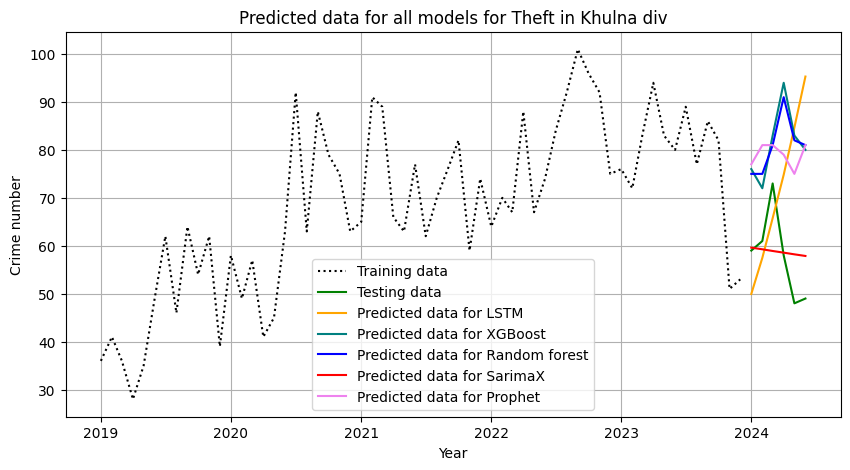

In [89]:
####################################################33
figure, ax = plt.subplots(figsize=(10, 5))

#df_data_train['Month']=pd.to_datetime(df_data_train['Month'].astype(str),format='%Y%m')
#df_data_test['Month']=pd.to_datetime(df_data_test['Month'].astype(str),format='%Y%m')

plt.title(f"Predicted data for all models for {crime_type} in {area}")
plt.xlabel('Year')
plt.ylabel('Crime number')

plt.plot(df_data_train['Datetime'],y_train_lstm, label="Training data",color='black',linestyle=':')
plt.plot(df_data_test['Datetime'],y_test_lstm, label="Testing data",color='green')
plt.plot(df_data_test['Datetime'],pred_lstm_rescaled, label="Predicted data for LSTM",color='orange')
plt.plot(df_data_test['Datetime'],preds_xgb, label='Predicted data for XGBoost',color='teal')
plt.plot(df_data_test['Datetime'],preds_gbc, label="Predicted data for Random forest",color='blue')
plt.plot(df_data_test['Datetime'], forecast_arima, label='Predicted data for SarimaX', color='red')
plt.plot(df_data_test['Datetime'],predicted_data_24.yhat, label='Predicted data for Prophet',color='violet')

plt.legend()
plt.grid()
plt.show()